# Multivariate Fuzzy C-medoids method: Implementation

## Equations

### $J= \sum_{i=1}^{c} \sum_{k=1}^{n} \sum_{j=1}^{p} \left(u_{ijk} \right)^{m} d_{ijk}$ - Objective function to minimize.

### $d_{ijk} = \left(x_{jk} - y_{ij} \right)^{2}$ - euclidian distance squared.

### $q = \argmin_{1 \le i \le c} \sum_{j=1}^p \sum_{k=1}^n (u_{ijk})^m \cdot d_{ijk}$ - prototype coordinate of a given cluster in feature j.

### $ u_{ijk} =  \left[\sum_{h=1}^{c}\sum_{l=1}^{p} \left(\frac{d_{ijk}}{d_{hlk}}\right)^{(1/(m-1))}  \right]^{-1} $ - membership degree of pattern k in cluster $C_{i}$ on the feature j.

### $\delta_{ik} = \sum_{j=1}^{p} u_{ijk}$ - represents an aggregation measure for all the p features.

## Constraints:

### - $u_{ijk} \in [0, 1]$ for all i, j and k;
### - $0 < \sum_{j=1}^{p} \sum_{k=1}^{n} u_{ijk} < n$ for all i and
### - $\sum_{i=1}^{c}\sum_{j=1}^{p}u_{ijk} = 1$ for all k.

## Importando bibliotecas

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

## Tratamento dos dados

In [3]:
df = pd.read_csv('/workspaces/Fuzzy_Clustering/datasets/wine.csv')
df = df.rename(columns={'Wine': 'Class'})
df["Class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)
labels = df["Class"].values
df = df.drop("Class", axis=1)
#df = df[["Alcohol", "Malic.acid", "Proline"]]
dados = df.to_numpy()
scaler = StandardScaler()
#scaler = MinMaxScaler()
dados = scaler.fit_transform(dados)

/tmp/ipykernel_2342/157194661.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Class"].replace({1: 0, 2: 1, 3: 2}, inplace=True)


In [4]:
df.head()

,Alcohol,Malic.acid,Ash,Acl,Mg,Phenols,Flavanoids,Nonflavanoid.phenols,Proanth,Color.int,Hue,OD,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [31]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df.drop(columns="Class")),
    columns=df.drop(columns="Class").columns
)
df_scaled["Class"] = df["Class"].values

# calcular média e desvio padrão por classe
mean_per_class = df_scaled.groupby("Class").mean()
std_per_class = df_scaled.groupby("Class").std()

print("Médias por classe:\n", mean_per_class)
print("\nDesvios padrão por classe:\n", std_per_class)

Médias por classe:
         Alcohol  Malic.acid       Ash       Acl        Mg   Phenols  \
Class                                                                 
0      0.714407    0.251122  0.585879  0.331819  0.394989  0.641438   
1      0.328614    0.235707  0.473149  0.496806  0.266840  0.440991   
2      0.558882    0.512599  0.575980  0.557560  0.318614  0.240948   

       Flavanoids  Nonflavanoid.phenols   Proanth  Color.int       Hue  \
Class                                                                    
0        0.557463              0.301887  0.469818   0.362483  0.473198   
1        0.367267              0.440872  0.384947   0.154148  0.468522   
2        0.093135              0.599057  0.234556   0.521864  0.164804   

             OD   Proline  
Class                      
0      0.691501  0.597512  
1      0.555074  0.172259  
2      0.151480  0.250996  

Desvios padrão por classe:
         Alcohol  Malic.acid       Ash       Acl        Mg   Phenols  \
Class        

## Método de agrupamento

In [5]:
class MFCMedoids:
    def __init__(self, c, X, m):
        self.c = c
        self.n = X.shape[0]
        self.p = X.shape[1]
        self.m = m
        self.epsilon = 1e-10  # To prevent division by zero

    def initialize_u(self):
        return np.random.dirichlet(alpha=np.ones(self.c * self.p),
                                   size=self.n).reshape(self.n, self.c, self.p)

    def find_medoids(self, X, U):
        medoids = np.zeros((self.c, self.p))
        U_m = U ** self.m  # (n, c, p)

        # Para cada possível q (0 <= q < n), criamos um tensor de distâncias quadradas para todos os outros k e p
        # (n, n, p) -> distances_squared[k, q, j] = (X[k, j] - X[q, j]) ** 2
        distances_squared = (X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2  # shape (n, n, p)

        for i in range(self.c):
            # Para o cluster i, obtemos U_m[:, i, :] -> shape (n, p)
            # Queremos calcular o custo de cada q ser o medoide: somatório sobre j e k de u_m[k, i, j] * d(k, q, j)
            
            # Expand u_m para fazer broadcast: (n, 1, p) para multiplicar com (n, n, p)
            u_m_expanded = U_m[:, i, :][:, np.newaxis, :]  # shape (n, 1, p)

            # Custo total para cada q: soma sobre k e j
            cost_per_q = np.sum(u_m_expanded * distances_squared, axis=(0, 2))  # shape (n,)

            best_q = np.argmin(cost_per_q)
            medoids[i] = X[best_q]

        return medoids


    def get_distances(self, X, medoids):
        return (X[:, np.newaxis, :] - medoids[np.newaxis, :, :]) ** 2

    def update_u(self, D):
        D = np.maximum(D, self.epsilon)  # Avoid division by zero
        ratio = (D[:, np.newaxis, np.newaxis, :, :] / D[:, :, :, np.newaxis, np.newaxis]) ** (1 / (self.m - 1))
        return 1 / np.sum(ratio, axis=(3, 4))

    def get_objective_function(self, U, D):
        return np.sum((U ** self.m) * D)

# Clustering

In [6]:
def mfcm_run(dados, num_clusters, m=2, max_iter=1000, epsilon=1e-5):
    mfcm = MFCMedoids(c=num_clusters, X=dados, m=m)  # Create the MFCMedoids object

    U = mfcm.initialize_u()  # Initialize the membership matrix

    for _ in range(max_iter):
        medoids = mfcm.find_medoids(dados, U)
        D = mfcm.get_distances(dados, medoids)
        new_U = mfcm.update_u(D)
        
        # Check for convergence
        if np.linalg.norm(U - new_U) < epsilon:
            break
        
        U = new_U

    Delta = np.sum(U, axis=2)  # Summing over the second axis (variables j)

    return medoids, U, Delta

## Simulação de Monte Carlo

In [7]:
def monte_carlo_simulation(dados, labels, num_clusters, num_trials):
    results = []
    for _ in range(num_trials):
        print(_)
        medoids, U, Delta = mfcm_run(dados, num_clusters)
        predicted_labels = np.argmax(Delta, axis=1)
        ari = adjusted_rand_score(labels, predicted_labels)
        if ari > 0.1:
            results.append(ari)
    mean_rand_index = np.mean(results)
    std_rand_index = np.std(results)
    return mean_rand_index, std_rand_index

In [52]:
medoids = monte_carlo_simulation(dados, labels, num_clusters=3, num_trials=100)
medoids

0
1
2


array([[0.83947368, 0.18972332, 0.5026738 , 0.29381443, 0.52173913,
        0.76551724, 0.56118143, 0.24528302, 0.51104101, 0.43515358,
        0.37398374, 0.74725275, 0.4935806 ],
       [0.35      , 0.61067194, 0.54545455, 0.53608247, 0.19565217,
        0.45517241, 0.12236287, 0.69811321, 0.19873817, 0.54351536,
        0.06504065, 0.11355311, 0.17261056],
       [0.35      , 0.61067194, 0.54545455, 0.53608247, 0.19565217,
        0.45517241, 0.12236287, 0.69811321, 0.19873817, 0.54351536,
        0.06504065, 0.11355311, 0.17261056]])

In [44]:
num_clusters = 3
num_trials = 100
mean_rand_index, std_rand_index = monte_carlo_simulation(dados, labels, num_clusters, num_trials)

print(f"Mean ARI: {mean_rand_index}")
print(f"Std ARI: {std_rand_index}")

0
1
2


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Mean ARI: 0.5324629486969259
Std ARI: 1.1102230246251565e-16


In [9]:
def medoide_global_calc(dados, u_ijk, m=2):
    n_objetos, p_variaveis = dados.shape
    u_ijk_m = u_ijk ** m
    pesos_kj = np.sum(u_ijk_m, axis=0).T

    min_dissimilarity = np.inf
    medoid_index = -1

    for q in range(n_objetos):  # test each point as medoid
        candidato_q = dados[q, :]
        distancias_sq = (dados - candidato_q) ** 2  # squared Euclidean
        dissimilaridade_total_q = np.sum(pesos_kj * distancias_sq)

        if dissimilaridade_total_q < min_dissimilarity:
            min_dissimilarity = dissimilaridade_total_q
            medoid_index = q

    return dados[medoid_index, :]


def indices(dados, prototipos, u_ijk, m=2):
    n, p = dados.shape
    c, _, _ = u_ijk.shape
    u_ijk_m = u_ijk ** m

    grupo_nomes = [f'Grupo_{i+1}' for i in range(c)]
    variavel_nomes = [f'Var_{j+1}' for j in range(p)]

    # global medoid
    z = medoide_global_calc(dados, u_ijk, m)

    # --- 1. Intra-group (J) ---
    dist_intra = (dados.T.reshape(1, p, n) - prototipos.reshape(c, p, 1)) ** 2
    J_ijk = u_ijk_m * dist_intra
    J = np.sum(J_ijk)
    J_por_grupo = np.sum(J_ijk, axis=(1, 2))
    J_por_variavel = np.sum(J_ijk, axis=(0, 2))
    J_ij = np.sum(J_ijk, axis=2)

    # --- 2. Inter-group (B) ---
    dist_inter = (prototipos - z) ** 2
    B_ijk = u_ijk_m * dist_inter.reshape(c, p, 1)
    B = np.sum(B_ijk)
    B_por_variavel = np.sum(B_ijk, axis=(0, 2))
    B_por_grupo = np.sum(B_ijk, axis=(1, 2))
    B_ij = np.sum(B_ijk, axis=2)

    # --- 3. Total (T = B + J) ---
    T = B + J
    T_por_variavel = B_por_variavel + J_por_variavel
    T_por_grupo = B_por_grupo + J_por_grupo
    T_ij = B_ij + J_ij

    # --- 4. Indices ---
    R_global = B / T if T > 0 else 0

    COR_j = np.divide(B_por_variavel, T_por_variavel, out=np.zeros_like(B_por_variavel), where=T_por_variavel!=0)
    CTR_j = np.divide(B_por_variavel, B, out=np.zeros_like(B_por_variavel), where=B!=0)
    df_indices_variavel = pd.DataFrame({'COR(j)': COR_j, 'CTR(j)': CTR_j}, index=variavel_nomes)

    T_i_rel = np.divide(T_por_grupo, T, out=np.zeros_like(T_por_grupo), where=T!=0)
    J_i_rel = np.divide(J_por_grupo, J, out=np.zeros_like(J_por_grupo), where=J!=0)
    B_i_rel = np.divide(B_por_grupo, B, out=np.zeros_like(B_por_grupo), where=B!=0)
    df_indices_grupo = pd.DataFrame({'T(i)': T_i_rel, 'J(i)': J_i_rel, 'B(i)': B_i_rel}, index=grupo_nomes)

    COR_ij = np.divide(B_ij, T_por_variavel, out=np.zeros_like(B_ij), where=T_por_variavel!=0)
    df_cor_ij = pd.DataFrame(COR_ij.T, index=variavel_nomes, columns=grupo_nomes)

    CTR_ij = np.divide(B_ij, B_por_grupo.reshape(-1, 1), out=np.zeros_like(B_ij), where=B_por_grupo.reshape(-1, 1)!=0)
    df_ctr_ij = pd.DataFrame(CTR_ij.T, index=variavel_nomes, columns=grupo_nomes)

    CE_ij = np.divide(B_ij, B, out=np.zeros_like(B_ij), where=B!=0)
    df_ce_ij = pd.DataFrame(CE_ij.T, index=variavel_nomes, columns=grupo_nomes)

    return {
        'T_total_bruto': T,
        'B_total_bruto': B,
        'J_total_bruto': J,
        'dispersao_bruta_por_grupo': pd.DataFrame({'Ti': T_por_grupo, 'Bi': B_por_grupo, 'Ji': J_por_grupo}, index=grupo_nomes),
        'dispersao_bruta_por_variavel': pd.DataFrame({'Tj': T_por_variavel, 'Bj': B_por_variavel, 'Jj': J_por_variavel}, index=variavel_nomes),
        'T_ij_bruto': pd.DataFrame(T_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'B_ij_bruto': pd.DataFrame(B_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'J_ij_bruto': pd.DataFrame(J_ij.T, index=variavel_nomes, columns=grupo_nomes),
        'R_global': R_global,
        'indices_por_variavel': df_indices_variavel,
        'indices_por_grupo': df_indices_grupo,
        'COR(i,j)': df_cor_ij,
        'CTR(i,j)': df_ctr_ij,
        'CE(i,j)': df_ce_ij
    }



medoides_resultado, U_resultado, _ = mfcm_run(dados, num_clusters=3, m=2)
u_ijk_para_analise = U_resultado.transpose(1, 2, 0)

indices = indices(
    dados=dados, 
    prototipos=medoides_resultado, 
    u_ijk=u_ijk_para_analise, 
    m=2
)

print("--- 1. Medidas de Dispersão Bruta Totais ---")
print(f"  T (Dispersão Total): {indices['T_total_bruto']:.4f}")
print(f"  B (Dispersão Inter-grupo): {indices['B_total_bruto']:.4f}")
print(f"  J (Dispersão Intra-grupo): {indices['J_total_bruto']:.4f}\n")

print("--- 2. Medidas de Dispersão Bruta por Grupo (Ti, Bi, Ji) ---")
print(indices['dispersao_bruta_por_grupo'])

print("\n--- 3. Medidas de Dispersão Bruta por Variável (Tj, Bj, Jj) ---")
print(indices['dispersao_bruta_por_variavel'])

print("\n--- 4. Medida de Dispersão Bruta T_ij ---")
print(indices['T_ij_bruto'])

print("\n--- 5. Medida de Dispersão Bruta B_ij ---")
print(indices['B_ij_bruto'])

print("\n--- 6. Medida de Dispersão Bruta J_ij ---")
print(indices['J_ij_bruto'])

print("--- 7. Índices Globais ---")
print(f"  R (Heterogeneidade Global): {indices['R_global']:.4f}\n")

print("--- 8. Índices por Variável (CORj, CTRj) ---")
print(indices['indices_por_variavel'])

print("\n--- 9. Índices de Contribuição Relativa por Grupo (T(i), B(i), J(i)) ---")
print(indices['indices_por_grupo'])

print("\n--- 10. Índice COR(i,j) ---")
print(indices['COR(i,j)'])

print("\n--- 11. Índice CTR(i,j) ---")
print(indices['CTR(i,j)'])

print("\n--- 12. Índice CE(i,j) ---")
print(indices['CE(i,j)'])

--- 1. Medidas de Dispersão Bruta Totais ---
  T (Dispersão Total): 94.1980
  B (Dispersão Inter-grupo): 38.2700
  J (Dispersão Intra-grupo): 55.9280

--- 2. Medidas de Dispersão Bruta por Grupo (Ti, Bi, Ji) ---
                Ti         Bi        Ji
Grupo_1  31.399337  12.756657  18.64268
Grupo_2  31.399337  12.756657  18.64268
Grupo_3  31.399337  12.756657  18.64268

--- 3. Medidas de Dispersão Bruta por Variável (Tj, Bj, Jj) ---
               Tj         Bj         Jj
Var_1   24.492432  12.136111  12.356321
Var_2   29.756536  13.575722  16.180814
Var_3    1.846452   0.069741   1.776711
Var_4    1.839648   0.005996   1.833652
Var_5    4.389328   2.370764   2.018564
Var_6    5.379575   2.496869   2.882706
Var_7    2.033368   0.536460   1.496908
Var_8    2.866915   1.164286   1.702629
Var_9    5.770212   0.452525   5.317687
Var_10   1.396077   0.364051   1.032026
Var_11   1.586055   0.328523   1.257531
Var_12   7.045388   1.953672   5.091716
Var_13   5.796024   2.815251   2.980773

--

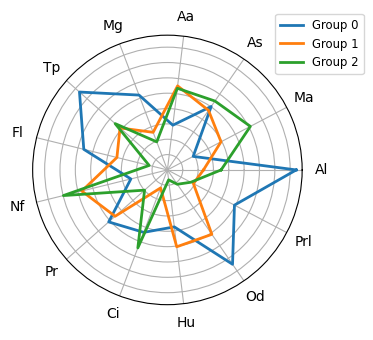

In [ ]:
prototipos_wine = np.array([
    [0.83947368, 0.18972332, 0.5026738 , 0.29381443, 0.52173913,
     0.76551724, 0.56118143, 0.24528302, 0.51104101, 0.43515358,
     0.37398374, 0.74725275, 0.4935806 ],
    [0.23514664, 0.39456456, 0.4716789, 0.5518277, 0.26217887,
     0.41254552, 0.33896520, 0.57458625, 0.45545931, 0.1254780,
     0.504593, 0.51, 0.19128741],
    [0.35      , 0.61067194, 0.54545455, 0.53608247, 0.19565217,
     0.45517241, 0.12236287, 0.69811321, 0.19873817, 0.54351536,
     0.06504065, 0.11355311, 0.17261056]
])

labels = [
    'Al', 'Ma', 'As', 'Aa', 'Mg', 'Tp', 
    'Fl', 'Nf', 'Pr', 'Ci', 
    'Hu', 'Od', 'Prl'
]

#labels = [
 #   'Alcohol', 'Malic.acid', 'Ash', 'Acl', 'Mg', 'Phenols', 
 #   'Flavanoids', 'Nonflavanoid.phenols', 'Proanth', 'Color.int', 
  #  'Hue', 'OD', 'Proline'
#]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(3.5, 3.5), subplot_kw=dict(polar=True))

for i, prototipo in enumerate(prototipos_wine):
    data = np.concatenate((prototipo, [prototipo[0]]))
    ax.plot(angles, data, label=f'Group {i}', linewidth=2)
    #ax.fill(angles, data, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_yticklabels([])
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.1), fontsize='small')

plt.savefig("radarE.pdf", format="pdf", bbox_inches="tight")

plt.show()

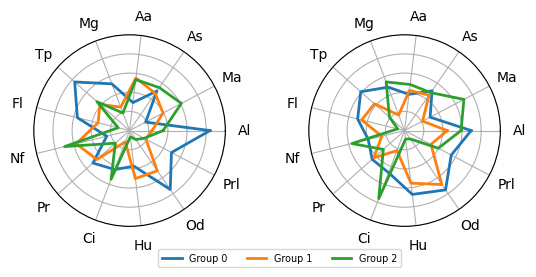

In [4]:
# First set of prototypes
prototipos_E = np.array([
    [0.83947368, 0.18972332, 0.5026738 , 0.29381443, 0.52173913,
     0.76551724, 0.56118143, 0.24528302, 0.51104101, 0.43515358,
     0.37398374, 0.74725275, 0.4935806 ],
    [0.23514664, 0.39456456, 0.4716789,  0.5518277,  0.26217887,
     0.41254552, 0.33896520, 0.57458625, 0.45545931, 0.1254780,
     0.504593,   0.51,       0.19128741],
    [0.35,        0.61067194, 0.54545455, 0.53608247, 0.19565217,
     0.45517241, 0.12236287, 0.69811321, 0.19873817, 0.54351536,
     0.06504065, 0.11355311, 0.17261056]
])

# Second set of prototypes
prototipos_C = np.array([
    [0.69462451, 0.30102398, 0.50486323, 0.38088541, 0.48462558, 0.61117455, 
     0.50463021, 0.39018754, 0.45255102, 0.47012358, 0.67152140, 0.75235684,
     0.55011285],
    [0.44473684, 0.21146245, 0.44919786, 0.42268041, 0.17391304, 0.42068966,
     0.46202532, 0.24528302, 0.42902208, 0.22354949, 0.55284553, 0.68498168,
     0.31098431],
    [0.58947368, 0.69960474, 0.48128342, 0.48453608, 0.54347826, 0.21034483,
     0.07383966, 0.56603774, 0.29652997, 0.76109215, 0.08943089, 0.10622711,
     0.39728959]
])

labels = ['Al', 'Ma', 'As', 'Aa', 'Mg', 'Tp', 
          'Fl', 'Nf', 'Pr', 'Ci', 'Hu', 'Od', 'Prl']

num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
# Two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(5.65, 2.825), subplot_kw=dict(polar=True))

# Function to plot radar (no legend here)
def plot_radar(ax, prototipos):
    for i, prototipo in enumerate(prototipos):
        data = np.concatenate((prototipo, [prototipo[0]]))
        ax.plot(angles, data, label=f'Group {i}', linewidth=2)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    
    # --- THIS IS THE FIX ---
    # Force the radial axis (y-axis) to range from 0 to 1
    ax.set_ylim(0, 1)
    
    # This line (which you already had) hides the labels like "0.2", "0.4"
    ax.set_yticklabels([])

# Left: MFCMd-E
plot_radar(axes[0], prototipos_E)

# Right: MFCMd-C
plot_radar(axes[1], prototipos_C)

# Extract legend handles/labels from the first axis
handles, labels_legend = axes[0].get_legend_handles_labels()

# Place one shared legend at the bottom center
fig.legend(handles, labels_legend, loc='lower center', bbox_to_anchor=(0.52, 0.05), ncol=3, fontsize='x-small')
plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("Figure_9.pdf", format="pdf", bbox_inches="tight")
plt.show()

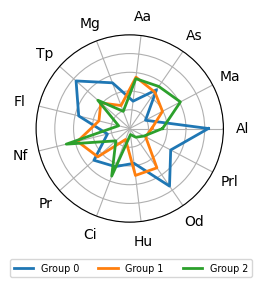

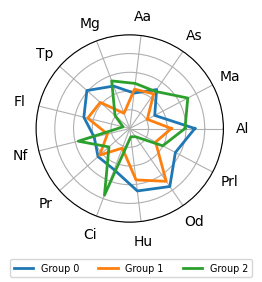

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Common setup ---
labels = ['Al', 'Ma', 'As', 'Aa', 'Mg', 'Tp', 
          'Fl', 'Nf', 'Pr', 'Ci', 'Hu', 'Od', 'Prl']

num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

def plot_radar(filename, prototipos):
    fig, ax = plt.subplots(figsize=(2.825, 2.825), subplot_kw=dict(polar=True))

    for i, prototipo in enumerate(prototipos):
        data = np.concatenate((prototipo, [prototipo[0]]))
        ax.plot(angles, data, label=f'Group {i}', linewidth=2)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_ylim(0, 1)
    ax.set_yticklabels([])

    # --- Legend setup ---
    handles, labels_legend = ax.get_legend_handles_labels()
    fig.legend(handles, labels_legend, loc='lower center', ncol=3, fontsize='x-small')

    # --- Tighter layout: reduce space between plot and legend ---
    plt.tight_layout(rect=[0, 0.05, 1, 1])  # smaller bottom margin

    # Save and show
    plt.savefig(filename, format="pdf", bbox_inches="tight")
    plt.show()
    plt.close(fig)

# --- Your data ---
prototipos_E = np.array([
    [0.83947368, 0.18972332, 0.5026738 , 0.29381443, 0.52173913,
     0.76551724, 0.56118143, 0.24528302, 0.51104101, 0.43515358,
     0.37398374, 0.74725275, 0.4935806 ],
    [0.23514664, 0.39456456, 0.4716789,  0.5518277,  0.26217887,
     0.41254552, 0.33896520, 0.57458625, 0.45545931, 0.1254780,
     0.504593,   0.51,       0.19128741],
    [0.35,        0.61067194, 0.54545455, 0.53608247, 0.19565217,
     0.45517241, 0.12236287, 0.69811321, 0.19873817, 0.54351536,
     0.06504065, 0.11355311, 0.17261056]
])

prototipos_C = np.array([
    [0.69462451, 0.30102398, 0.50486323, 0.38088541, 0.48462558, 0.61117455, 
     0.50463021, 0.39018754, 0.45255102, 0.47012358, 0.67152140, 0.75235684,
     0.55011285],
    [0.44473684, 0.21146245, 0.44919786, 0.42268041, 0.17391304, 0.42068966,
     0.46202532, 0.24528302, 0.42902208, 0.22354949, 0.55284553, 0.68498168,
     0.31098431],
    [0.58947368, 0.69960474, 0.48128342, 0.48453608, 0.54347826, 0.21034483,
     0.07383966, 0.56603774, 0.29652997, 0.76109215, 0.08943089, 0.10622711,
     0.39728959]
])

# --- Generate and display ---
plot_radar("radar1.pdf", prototipos_E)
plot_radar("radar2.pdf", prototipos_C)
